[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1g_mnist_fc.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1g_mnist_fc.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1g_mnist_fc.ipynb)
[![SageMaker](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1g_mnist_fc.ipynb)

# Clasificación de MNIST con un red densa

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---
---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes de dígitos implementando una red densa multicapa en PyTorch.

Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Está compuesto de imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600"/>
Conjunto MNIST. Imagen tomada de Wikipedia.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### 1.2 Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/f79e17e7aaf27b8c2cbae98c947a33b347ff0e8a/figs/mnist_tuberia.svg" width="1050"/>
&nbsp;
Tuberia de datos para MNIST.

### 2.2 Exploración

PyTorch provee la clase [`MNIST`](https://pytorch.org/vision/0.8/datasets.html#mnist), una implementación de `Dataset` lista para usar del conjunto MNIST.

In [4]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


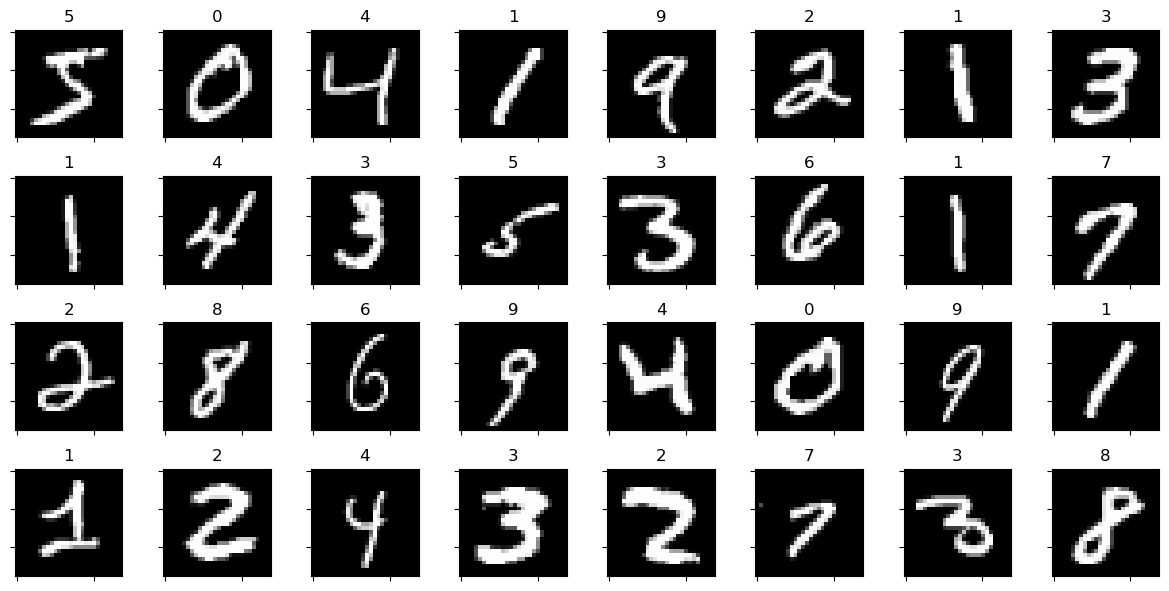

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

### 2.3 Cargadores de datos

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>

&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


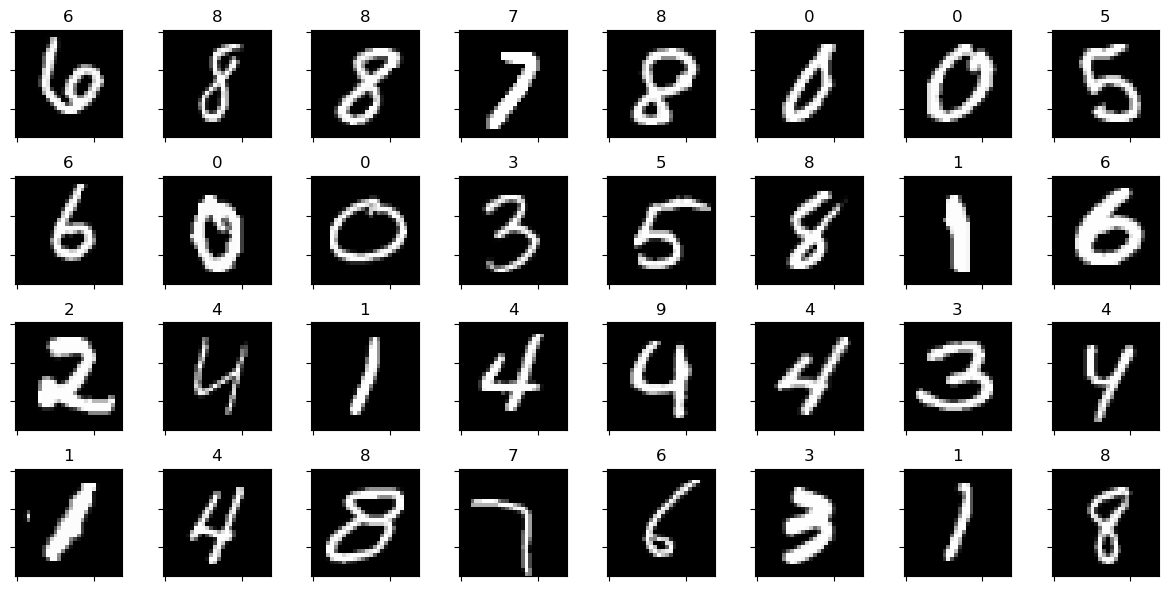

In [6]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


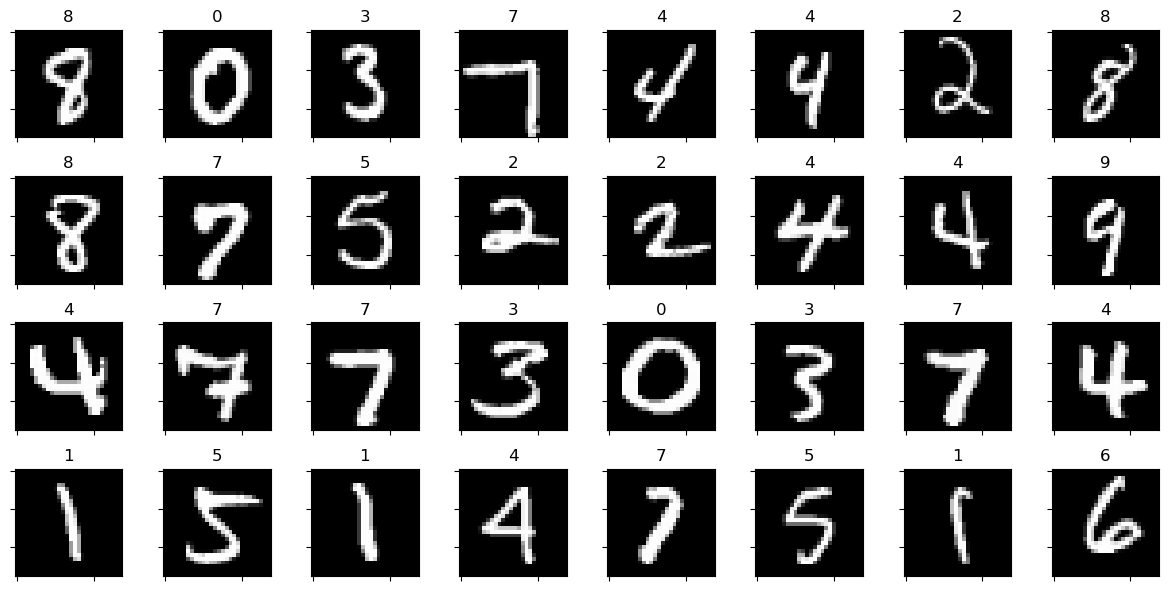

In [7]:
# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/fc_arch.svg" width="800"/>
&nbsp;
Arquitectura de la red completamente conectada.

### 3.1 Definición de la arquitectura

In [8]:
# definición del modelo
class FCN(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 3.2 Instancia de la arquitectura

In [9]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [10]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [11]:
summary(model, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─Sigmoid: 2-3                      [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 10]
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/dbf3441f7d73c5cccada48d9813636e5b083a487/figs/supervisado.svg" width="800"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [12]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos un modelo:

In [13]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[224.82,224.77] acc=[25.37,25.98]
E01 loss=[219.20,219.03] acc=[48.70,49.42]
E02 loss=[212.35,212.02] acc=[54.13,55.43]
E03 loss=[203.83,203.35] acc=[60.40,61.07]
E04 loss=[193.47,192.79] acc=[63.13,63.80]
E05 loss=[181.55,180.61] acc=[66.00,66.81]
E06 loss=[168.69,167.56] acc=[68.57,69.46]
E07 loss=[155.65,154.30] acc=[69.91,70.76]
E08 loss=[143.16,141.70] acc=[71.66,72.47]
E09 loss=[131.71,130.14] acc=[73.98,74.73]
E10 loss=[121.50,119.83] acc=[76.19,76.88]
E11 loss=[112.60,110.89] acc=[77.54,78.21]
E12 loss=[104.90,103.17] acc=[78.71,79.28]
E13 loss=[ 98.28, 96.58] acc=[79.74,80.15]
E14 loss=[ 92.53, 90.77] acc=[80.86,81.17]
E15 loss=[ 87.56, 85.80] acc=[81.53,81.92]
E16 loss=[ 83.23, 81.47] acc=[82.18,82.45]
E17 loss=[ 79.43, 77.70] acc=[82.75,83.13]
E18 loss=[ 76.08, 74.31] acc=[83.35,83.80]
E19 loss=[ 73.11, 71.36] acc=[83.81,84.31]


### 4.2 Gráficas de pérdidas y exactitud

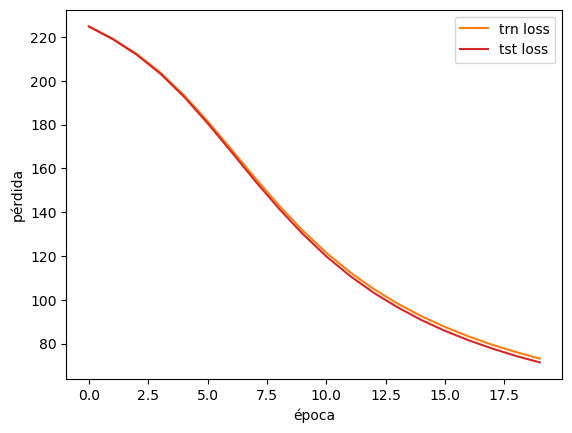

In [14]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

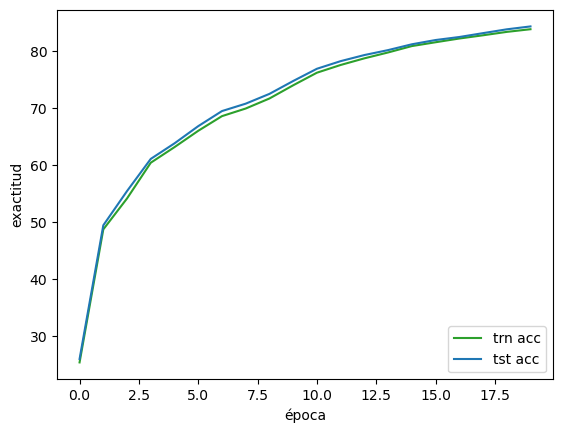

In [15]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [16]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 73.11, 71.36] acc=[83.81,84.33]


### 5.2 Inferencia

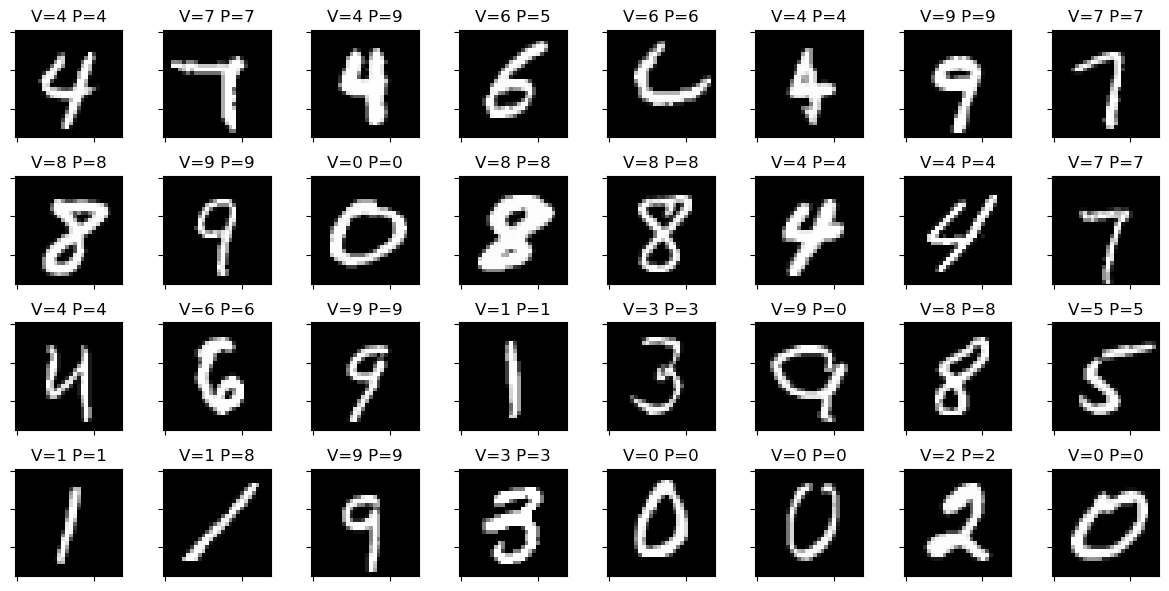

In [17]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## Participación

1. ¿Qué podemos hacer para mejorar el desempeño?
2. Remplaza la función de activación de la capa oculta por una [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), vuelve a entrenar y compara tus resultados.